# Import libraries :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import nltk
import string as mystr
from nltk.corpus import stopwords
nltk.download('stopwords')
RemoveWords = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Animals and Birds clusters considered :

In [2]:
WordsArray =np.array(["dog","tiger","cat","elephant","horse","bear","cow","monkey","deer","snake","lion","sparrow","parrot","dove","eagle","woodpecker","crane","owl","duck","cuckoo","penguin"])
AnimalWords = np.array(["dog","tiger","cat","elephant","horse","bear","cow","monkey","deer","snake","lion"])
BirdWords = np.array(["sparrow","parrot","dove","eagle","woodpecker","crane","owl","duck","cuckoo","penguin"])
cluster_df = np.array([0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])

# Defining necessary functions :

In [3]:
def softmax(x):
	e_x = np.exp(x - np.max(x))
	return e_x / e_x.sum()

In [4]:
def Clean_Corpus(corpus):
    #blank corpus set
    Corpus_set = []

    # split each sentences
    sentences = corpus.split(".") 
    #loop through each word in each sentence
    for eachWord in range(len(sentences)):

      #remove spaces
      sentences[eachWord] = sentences[eachWord].strip () 
      Eachsentence = sentences[eachWord].split() #split sentence by blank spaces          
      myWords = [word.strip(mystr.punctuation) for word in Eachsentence if word.lower() not in RemoveWords] #remove puntuations and stopword
      myWords = [word.lower() for word in myWords if word.lower() !=""] #remove blanks and make lower
     
      Corpus_set.append(myWords)# append to array of corpus set

    return Corpus_set

In [5]:
#This function create One hot encoding for Input word and the context words
def OneHotEncoding(sentences,model):
    mydata = {}
    for sentence in sentences:
        for word in sentence:
            if word not in mydata:
                mydata[word] = 1
            else:
                mydata[word] += 1
    V = len(mydata)

    mydata = sorted(list(mydata.keys()))
    
    for i in range(len(mydata)):
        model.vocab[mydata[i]] = i
      
    #for i in range(len(words)):
    for sentence in sentences:
        for i in range(len(sentence)):
            center_word = [0 for x in range(V)]
            center_word[model.vocab[sentence[i]]] = 1
            context = [0 for x in range(V)]
             
            for j in range(i-model.Context_Window,i+model.Context_Window):
                if i!=j and j>=0 and j<len(sentence):
                    context[model.vocab[sentence[j]]] += 1
                  
            model.X_train.append(center_word)
            model.y_train.append(context)

    #Initialize the weights of NN
    model.InitializeWeights(V,mydata)
  
    return model.X_train,model.y_train 

In [6]:
class SkipGramModel(object):
    def __init__(self):
        self.Neuron = 50
        self.lr = 0.005
        self.Context_Window = 2

        self.X_train = []
        self.y_train = []
        

        self.words = []
        self.word_index = {}
        self.vocab = {}
  
    def InitializeWeights(self,V,data):
        self.V = V
        self.W = np.random.uniform(-0.8, 0.8, (self.V, self.Neuron))
        self.W1 = np.random.uniform(-0.8, 0.8, (self.Neuron, self.V))
          
        self.words = data
        for i in range(len(data)):
            self.word_index[data[i]] = i
            
    def train(self,mytol,maxepochs=20000):
      	#initialize loss
        self.loss =0
        self.loss1 = 1 #random number 1
        itr=1
        
        while abs(self.loss1 - self.loss)>= mytol and itr <= maxepochs:
            self.loss1 = self.loss
            self.loss = 0
            for j in range(len(self.X_train)):

             		# implementing feedforward 
                self.h = np.dot(self.W.T,self.X_train[j]).reshape(self.Neuron,1)
                self.u = np.dot(self.W1.T,self.h)
                self.y = softmax(self.u)
                
                # implementation of back propogration
                error = self.y - np.asarray(self.y_train[j]).reshape(self.V,1)
                dLdW1 = np.dot(self.h,error.T)
                X = np.array(self.X_train[j]).reshape(self.V,1)
                dLdW = np.dot(X, np.dot(self.W1,error).T)

                self.W1 = self.W1 - self.lr*dLdW1
                self.W = self.W - self.lr*dLdW

                #loss Function
                C = 0
                for m in range(self.V):
                    if(self.y_train[j][m]):
                        self.loss += -1*self.u[m][0]
                        C += 1
                self.loss += C*np.log(np.sum(np.exp(self.u)))
            #Print loss
            print("epoch ",itr, " loss = ",self.loss)
            #update adaptive alpha
            self.lr *= 1/( (1+self.lr*itr) )
            itr=itr+1
             
    def predict(self,word,number_of_predictions):
        if word in self.words:
            index = self.word_index[word]
            X = [0 for i in range(self.V)]
            X[index] = 1


            #prediction = self.feed_forward(X)
            self.h = np.dot(self.W.T,X).reshape(self.Neuron,1)
            self.u = np.dot(self.W1.T,self.h)
            self.y = softmax(self.u)
            prediction=self.y


            output = {}
            for i in range(self.V):
                output[prediction[i][0]] = i
              
            top_context_words = []
            for k in sorted(output,reverse=True):
                top_context_words.append(self.words[output[k]])
                if(len(top_context_words)>=number_of_predictions):
                    break
      
            return top_context_words
        else:
            print("Word not found")

In [9]:
def Get_Embeding(myword,SkipGram):
  WeightMatrix = SkipGram.W1.T
  return WeightMatrix[SkipGram.word_index[myword]]
	
def cosine_similarity(word1, word2,SkipGram):
  temp = SkipGram.W1.T
  temp.shape
  a=Get_Embeding(word1,SkipGram)
  b=Get_Embeding(word2,SkipGram)
  dot_product = np.dot(a, b)
  norm_a = np.linalg.norm(a)
  norm_b = np.linalg.norm(b)
  return np.dot(a, b)/np.sqrt(np.dot(a, a)*np.dot(b, b))
  return dot_product / (norm_a * norm_b)


# Importing corpus :

In [10]:
filename = 'Corpus.txt'
data = np.loadtxt(filename, delimiter='\t', skiprows=0, dtype=str)
data
corpus = ""
for i in range(len(data)):
  corpus= corpus +"."+ data[i]
print(corpus)

.laves. Labradoodle A Labradoodle is a mixed-breed DOG, created by breeding a Labrador Retriever with  .reaction. Ms. Blum contacted the Australian Royal DOG Association, because dogs imported from Austra  .When a Labradoodle runs over to a less sociable DOG, the dog might become scared and irritable. La  .water buck, hyena, baboon, impala, African wild DOG and giraffe. The park also boasts about bi  .of bread. A bun can be either savoury (like a hot DOG) or sweet (like a hot cross bun or a bun with  .y unwanted Program. Poodle A poodle is a breed of DOG. Poodles are made to be one of the smartest do  .Boxer (DOG) The Boxer is a breed of dog. With good care,  .rmany and was originally bred for bull-bating and DOG fights, but when that was ruled out they were  .esian Ridgeback Rhodesian Ridgeback is a breed of DOG. It has a red-brown coat of fur on its body an  .body. They are sometimes called "The African Lion DOG", because they were used by hunters in Africa  .and mental characteristi

In [11]:
corpus_Set = Clean_Corpus(corpus)
print(" number of sentences :", len(corpus_Set))

 number of sentences : 1724


In [12]:
# # only if we want to export corpus
# df = pd.DataFrame (corpus_Set)
# filepath = 'CorpusSet.xlsx'
# df.to_excel(filepath, index=False)

# Creating Skipgram model and vocabulary set:

In [13]:
model = SkipGramModel()
Onehotencoding =OneHotEncoding(corpus_Set,model)
print("Number of words in vocabularly:", len(model.vocab))
print("Vocabulary Set : ",model.vocab)

Number of words in vocabularly: 2988
Vocabulary Set :  {'0': 0, '00': 1, '002': 2, '003': 3, '004': 4, '005': 5, '006': 6, '007': 7, '008': 8, '009': 9, '010': 10, '011': 11, '012': 12, '013': 13, '014': 14, '015': 15, '016': 16, '017': 17, '018': 18, '019': 19, '020': 20, '021': 21, '022': 22, '023': 23, '024': 24, '025': 25, '026': 26, '027': 27, '028': 28, '029': 29, '030': 30, '031': 31, '032': 32, '033': 33, '034': 34, '035': 35, '036': 36, '037': 37, '039': 38, '040': 39, '041': 40, '042': 41, '043': 42, '044': 43, '045': 44, '046': 45, '047': 46, '048': 47, '049': 48, '050': 49, '052': 50, '053': 51, '054': 52, '056': 53, '057': 54, '058': 55, '059': 56, '060': 57, '061': 58, '062': 59, '063': 60, '064': 61, '066': 62, '067': 63, '068': 64, '069': 65, '070': 66, '071': 67, '072': 68, '073': 69, '074': 70, '076': 71, '077': 72, '078': 73, '079': 74, '08': 75, '080': 76, '081': 77, '082': 78, '083': 79, '084': 80, '085': 81, '087': 82, '089': 83, '092': 84, '095': 85, '096': 86, '

# Training model :

In [14]:
maxepochs = 1000
tol= 1e-2
model.train(tol,maxepochs)

epoch  1  loss =  127918.05583046496
epoch  2  loss =  124748.785984727
epoch  3  loss =  121807.6694747424
epoch  4  loss =  119072.62909378942
epoch  5  loss =  116526.77289681313
epoch  6  loss =  114164.29230415278
epoch  7  loss =  111998.54848673064
epoch  8  loss =  110053.10380625076
epoch  9  loss =  108310.42471279224
epoch  10  loss =  106732.33129856027
epoch  11  loss =  105300.1349124423
epoch  12  loss =  104007.65082741612
epoch  13  loss =  102849.88999814763
epoch  14  loss =  101819.58826142267
epoch  15  loss =  100906.49604208748
epoch  16  loss =  100097.31084478418
epoch  17  loss =  99378.86668982498
epoch  18  loss =  98740.24989728926
epoch  19  loss =  98172.31617407616
epoch  20  loss =  97666.9167211869
epoch  21  loss =  97216.8645083359
epoch  22  loss =  96816.07470398142
epoch  23  loss =  96459.4937707864
epoch  24  loss =  96142.8807681827
epoch  25  loss =  95862.58071315652
epoch  26  loss =  95615.35072107728
epoch  27  loss =  95398.24637421043
ep

KeyboardInterrupt: ignored

#Predict Context

In [18]:
print(model.predict("penguin",4))

['fluffy', 'subspecies', 'little', 'island']

In [19]:
print(model.predict("cow",4))

['moo', 'milk', 'spiritual', 'holy']

In [20]:
print(model.predict("dog",2))

['Pup', 'owl']

In [21]:
print(model.predict("horse",4))

['Trojan', 'arabian', 'large', 'wooden']


In [22]:
print(model.predict("parrot",4))

['moorei', 'black-headed', 'beak']


In [23]:
print(model.predict("dove",4))

['mourning', 'symbol', 'the', 'insect']


# Cosine Similarity Matrix

In [24]:
Embedingarray= []
Values=np.zeros((21,21))
for i in range(len(WordsArray)):
    for j in range(len(WordsArray)):
        Values[i][j]=cosine_similarity(WordsArray[i], WordsArray[j],model)
        #print(WordsArray[i], WordsArray[j],Values[i][j])
    Embedingarray.append(Get_Embeding(WordsArray[i],model))
cos_mtx = pd.DataFrame(data=Values,columns=WordsArray,index=WordsArray)
cos_mtx

,dog,tiger,cat,elephant,horse,bear,cow,monkey,deer,snake,lion,sparrow,parrot,dove,eagle,woodpecker,crane,owl,duck,cuckoo,penguin
dog,1.000000,0.437010,0.212576,0.044385,0.239544,0.090968,0.297583,0.192757,0.042613,-0.095489,0.179595,0.105009,0.130334,0.236934,0.221978,0.187440,-0.007239,0.390395,-0.089868,0.072076,0.081065
tiger,0.437010,1.000000,0.125375,0.233057,0.289028,0.277274,0.194138,0.097722,-0.107876,0.169474,0.377545,-0.126505,-0.112977,0.093126,0.029349,0.093543,0.204459,0.193732,0.039498,-0.237753,0.143572
cat,0.212576,0.125375,1.000000,0.138274,0.141195,0.040685,0.192347,0.401632,-0.009267,0.029713,0.249434,-0.118929,0.260956,0.151008,0.039054,0.069856,-0.037639,0.191619,0.176641,0.125133,-0.091054
elephant,0.044385,0.233057,0.138274,1.000000,-0.010859,0.299593,0.058992,0.010622,0.047837,0.266011,0.193442,-0.035425,0.090758,0.009452,0.179587,0.067047,0.254253,0.170579,0.044694,0.318964,0.013745
horse,0.239544,0.289028,0.141195,-0.010859,1.000000,-0.070336,0.102185,0.282393,-0.283396,0.015002,0.205030,-0.023546,-0.206296,0.024654,0.253243,0.296185,-0.025907,-0.048290,0.076437,0.060044,-0.074107
bear,0.090968,0.277274,0.040685,0.299593,-0.070336,1.000000,0.113557,-0.117589,0.084297,0.110144,0.249397,0.058781,0.011746,0.156623,0.042881,-0.064189,0.179488,0.057480,0.089342,-0.069977,0.334849
cow,0.297583,0.194138,0.192347,0.058992,0.102185,0.113557,1.000000,0.207411,-0.008520,-0.177141,-0.020980,0.079042,0.326607,0.062708,0.342852,0.264832,0.213667,0.252264,0.142485,0.116379,-0.118647
monkey,0.192757,0.097722,0.401632,0.010622,0.282393,-0.117589,0.207411,1.000000,-0.298572,0.198209,-0.000879,0.057481,0.182514,0.445517,0.057230,0.126681,0.117590,0.103754,0.127140,0.168201,-0.119753
deer,0.042613,-0.107876,-0.009267,0.047837,-0.283396,0.084297,-0.008520,-0.298572,1.000000,-0.186445,-0.078304,0.169676,0.290901,-0.032624,-0.197224,0.121789,-0.076726,0.074167,-0.142538,0.024538,0.118432
snake,-0.095489,0.169474,0.029713,0.266011,0.015002,0.110144,-0.177141,0.198209,-0.186445,1.000000,0.026697,-0.071670,-0.067934,0.235790,0.269074,-0.172010,0.187852,-0.141525,0.255478,-0.107807,0.185022


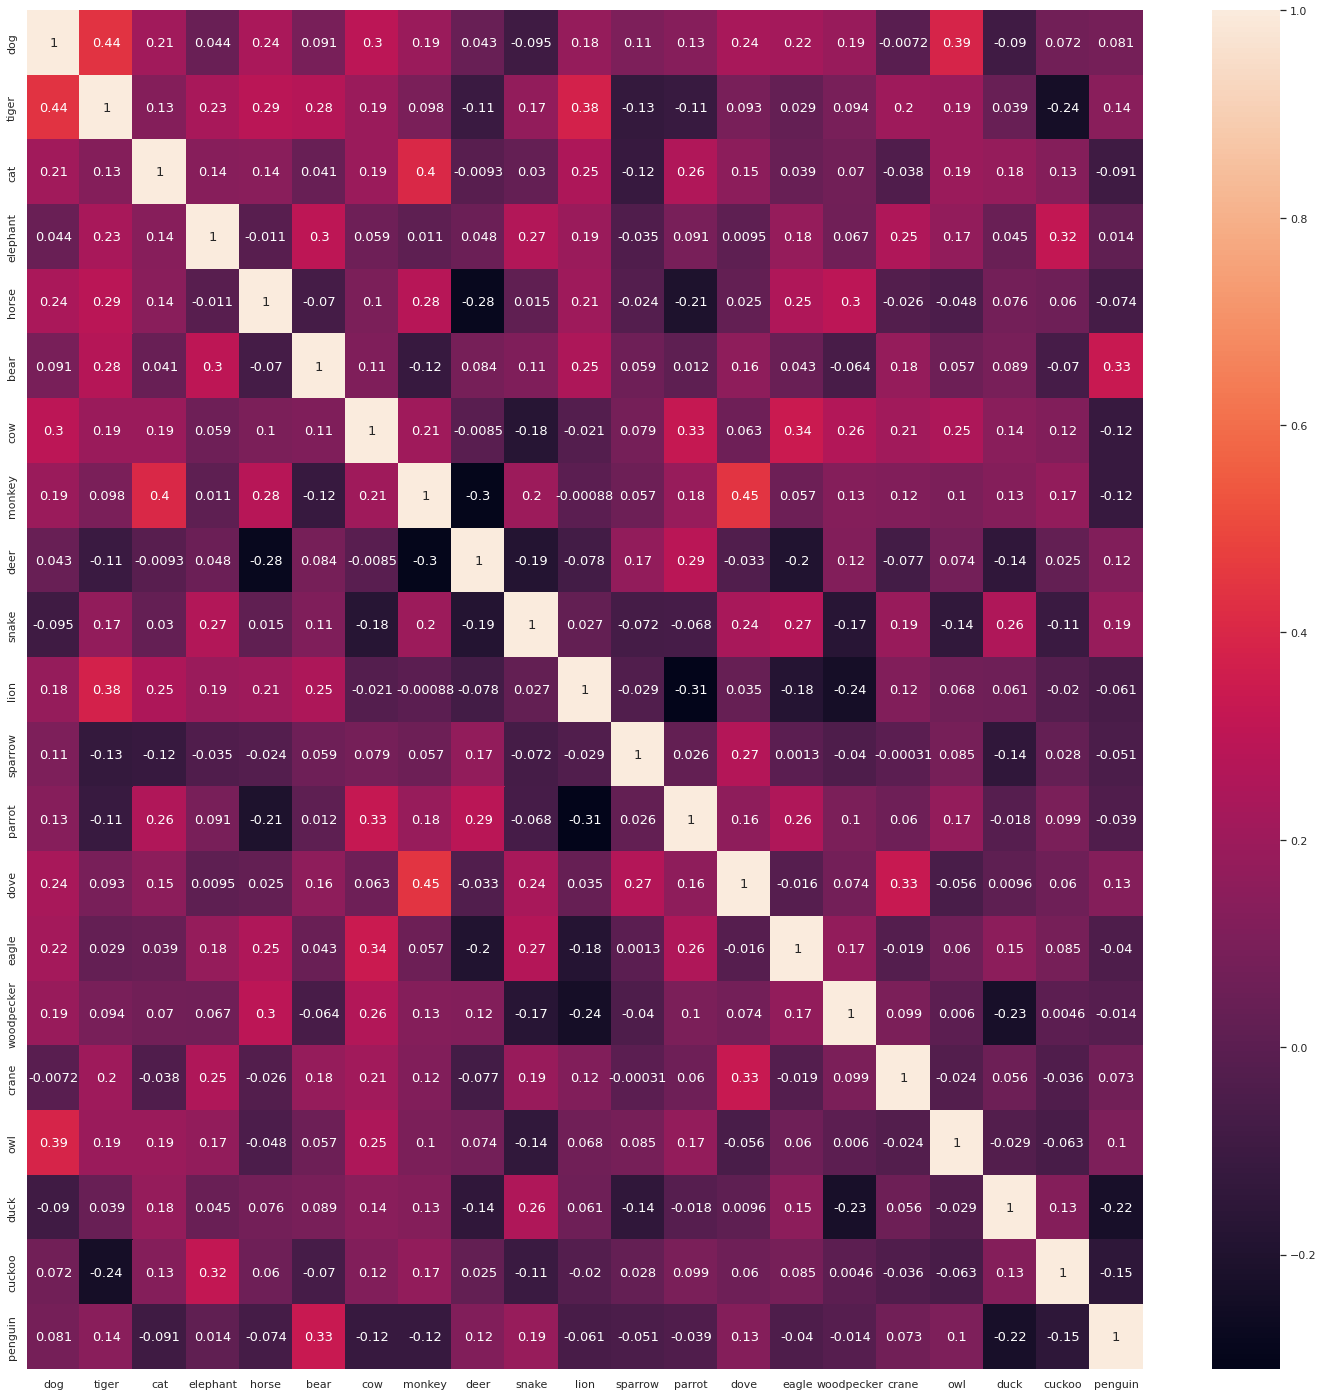

In [25]:
sns.set(rc={"figure.figsize":(25, 25)}) 
sns.heatmap(cos_mtx, annot=True, annot_kws={"size":13})

# Cluster Plot

In [26]:
word_ebd = pd.DataFrame(data=Embedingarray,index=WordsArray)
word_ebd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
dog,-1.523818,-0.388271,-0.144022,-0.036931,-0.538179,-0.829217,0.487544,-1.349914,0.711239,0.472288,1.870869,-0.177706,0.281870,0.425484,0.948141,-0.081708,0.065703,0.832803,1.409757,-0.624302,1.081091,-0.300639,0.177750,-0.130933,0.337013,1.383248,1.508473,0.241720,-0.525668,0.931044,-1.595717,-0.855561,-1.054887,-0.329438,-0.029745,-1.288589,0.888334,-0.450521,-0.685436,-0.752985,1.914460,-0.834817,1.003219,1.342540,1.280953,0.941758,-0.568776,-0.059215,0.561297,-0.670121
tiger,-0.320054,1.124179,0.212081,-0.072008,-0.799761,0.362597,-0.077101,0.112833,-0.592894,-0.692660,-0.139892,-1.647996,0.091690,0.076537,0.201166,-1.245827,1.577753,0.930640,1.005556,-1.328962,1.683131,0.100112,-0.583209,-0.030728,0.122635,2.322195,-0.752807,0.652318,0.741268,-0.784185,-2.169544,-0.587201,-0.764083,-1.034193,-1.101548,-0.420679,0.927079,-1.574722,-0.521707,-0.837707,0.307556,1.096472,0.429165,1.657999,1.040283,0.192681,-0.790028,0.904118,-0.545446,-1.400574
cat,-0.350169,2.133642,-1.397437,0.716572,-1.173068,1.242734,-0.843687,-0.945880,-1.904164,0.051972,-0.164339,1.151200,1.066286,0.745057,-0.270724,0.634409,0.974954,0.991855,0.211733,0.394434,0.598038,0.925916,0.339675,-0.216971,-0.660668,-0.883832,0.856419,0.050331,-1.507205,0.934333,-0.011286,-0.282009,0.606756,-0.727582,-0.110585,-1.187550,-1.122501,-0.148343,0.985652,-1.478053,2.021661,1.351776,0.750646,0.482807,1.494777,2.149146,0.448306,1.403574,-0.031349,1.125313
elephant,0.651745,0.356570,1.797324,0.185778,0.702629,1.150329,-1.434956,-0.867063,0.596465,-0.728878,-0.694683,-1.114773,-0.176692,-0.673898,1.244149,-0.633952,0.557578,1.770776,0.468916,-0.915007,0.850093,0.576883,-0.288902,-0.608813,-1.223130,-0.068977,0.362651,-1.640662,-1.038143,0.276439,-0.484439,-1.968648,-0.609703,-0.091215,1.281564,1.320361,0.476014,1.293866,-0.217820,-1.142642,-1.063778,2.467747,0.017720,0.214387,0.356772,1.789338,-0.575172,-0.622420,-1.069453,-0.027340
horse,-0.917133,-0.573871,-0.791762,2.294558,-1.462397,0.339770,-0.202151,0.849433,-0.335239,1.863997,0.579454,-2.409969,0.008527,1.358916,-1.034362,0.964091,-1.249762,-0.370733,2.545694,0.097177,1.542625,1.084069,-1.322458,0.672979,0.680339,-0.025904,-0.702318,0.068562,-1.027500,0.272672,0.142316,0.273894,-0.964560,0.155868,-1.253755,-0.089893,0.337053,-0.388694,-0.756845,-0.385027,0.367894,1.637459,1.393473,0.540217,-0.255348,0.531412,0.560891,0.406104,-0.189304,-1.584266
bear,0.118299,-0.300807,1.375711,-0.440273,0.424220,0.883179,0.485923,-0.204869,-0.030658,-0.569101,-0.728686,-1.329695,1.874600,-0.458776,2.057329,-1.455655,-0.726799,1.291472,1.369755,0.883534,0.552010,-2.918861,1.049848,-0.174229,0.231114,0.523208,-0.763310,1.234155,1.656701,-0.075556,-1.495809,-0.205109,-0.572740,-1.337744,0.749684,0.008159,-1.647119,0.815698,0.030913,-0.088596,0.008742,3.129649,-0.779737,0.026900,0.533131,1.126402,-0.573784,0.731969,1.446696,0.369948
cow,0.195254,1.007309,-0.279974,-0.231938,-0.392671,0.168825,-1.022616,-0.436369,-0.187136,-0.169134,2.059959,0.196142,0.660416,1.112753,-0.246707,0.606063,-0.371610,-1.262247,0.117759,-2.122561,0.188984,-1.030916,-0.061839,-0.092894,0.017784,0.601603,-0.003113,0.477374,-0.809238,0.056539,-1.362065,1.268363,-0.771843,-0.977767,0.491817,-0.516825,-0.223117,0.080599,0.752387,0.014676,-0.504046,0.650134,0.807858,-0.119778,0.544065,1.556119,-1.603958,-0.989827,0.499251,-0.055169
monkey,-0.444342,1.342194,-0.269737,1.194188,-1.394764,-1.452023,-1.542122,0.527748,-0.892613,1.255107,-0.904410,1.351253,1.042236,0.586167,-1.117354,-1.224978,-1.508738,-0.710438,-0.401969,0.354327,1.032436,1.616527,-0.772014,-1.549073,-0.083189,1.810265,1.367130,0.347729,-1.921648,1.936400,0.219775,0.208050,-0.139405,-1.936401,0.526284,0.144958,-0.608088,-1.172197,-0.882659,0.299290,1.405716,0.631585,0.835417,-0.610089,-0.431491,1.935805,-0.334506,0.537944,-0.429387,-0.748050
deer,0.112322,0.94

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(word_ebd)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'],index =WordsArray)
principal_np = principalDf.to_numpy()
myp1=principalDf["principal component 1"].to_numpy()
myp2=principalDf["principal component 2"].to_numpy()
myfinaldf = pd.DataFrame({'Words': WordsArray , 'PC1':myp1, "PC2" :myp2 , "Cluster" : cluster_df})
myfinaldf

,Words,PC1,PC2,Cluster
0,dog,0.466681,-1.552359,0
1,tiger,0.590141,2.349945,0
2,cat,-1.976426,-1.041154,0
3,elephant,0.645639,1.314567,0
4,horse,-3.028285,-0.028172,0
5,bear,3.362268,3.289927,0
6,cow,-0.533088,-1.969237,0
7,monkey,-4.050642,-0.978822,0
8,deer,4.496658,-2.589590,0
9,snake,-1.475135,4.480323,0


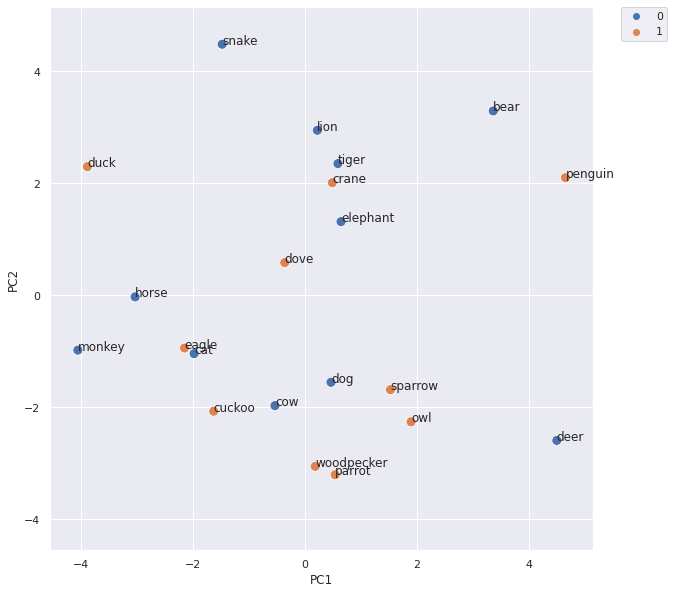

In [31]:

fig, ax = plt.subplots(1)
sns.set(rc={"figure.figsize":(15, 15)}) 
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=myfinaldf, ax=ax,s=100)
lim = (principal_np.min()-0.5, principal_np.max()+0.5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

for i in range(len(WordsArray)):
    
    plt.annotate(WordsArray[i], (principal_np[i,0], principal_np[i,1]))

plt.show()


# Plot the clusters using TSNE plot

In [32]:
word_ebd = pd.DataFrame(data=Embedingarray,index=WordsArray)
word_ebd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
dog,-1.523818,-0.388271,-0.144022,-0.036931,-0.538179,-0.829217,0.487544,-1.349914,0.711239,0.472288,1.870869,-0.177706,0.281870,0.425484,0.948141,-0.081708,0.065703,0.832803,1.409757,-0.624302,1.081091,-0.300639,0.177750,-0.130933,0.337013,1.383248,1.508473,0.241720,-0.525668,0.931044,-1.595717,-0.855561,-1.054887,-0.329438,-0.029745,-1.288589,0.888334,-0.450521,-0.685436,-0.752985,1.914460,-0.834817,1.003219,1.342540,1.280953,0.941758,-0.568776,-0.059215,0.561297,-0.670121
tiger,-0.320054,1.124179,0.212081,-0.072008,-0.799761,0.362597,-0.077101,0.112833,-0.592894,-0.692660,-0.139892,-1.647996,0.091690,0.076537,0.201166,-1.245827,1.577753,0.930640,1.005556,-1.328962,1.683131,0.100112,-0.583209,-0.030728,0.122635,2.322195,-0.752807,0.652318,0.741268,-0.784185,-2.169544,-0.587201,-0.764083,-1.034193,-1.101548,-0.420679,0.927079,-1.574722,-0.521707,-0.837707,0.307556,1.096472,0.429165,1.657999,1.040283,0.192681,-0.790028,0.904118,-0.545446,-1.400574
cat,-0.350169,2.133642,-1.397437,0.716572,-1.173068,1.242734,-0.843687,-0.945880,-1.904164,0.051972,-0.164339,1.151200,1.066286,0.745057,-0.270724,0.634409,0.974954,0.991855,0.211733,0.394434,0.598038,0.925916,0.339675,-0.216971,-0.660668,-0.883832,0.856419,0.050331,-1.507205,0.934333,-0.011286,-0.282009,0.606756,-0.727582,-0.110585,-1.187550,-1.122501,-0.148343,0.985652,-1.478053,2.021661,1.351776,0.750646,0.482807,1.494777,2.149146,0.448306,1.403574,-0.031349,1.125313
elephant,0.651745,0.356570,1.797324,0.185778,0.702629,1.150329,-1.434956,-0.867063,0.596465,-0.728878,-0.694683,-1.114773,-0.176692,-0.673898,1.244149,-0.633952,0.557578,1.770776,0.468916,-0.915007,0.850093,0.576883,-0.288902,-0.608813,-1.223130,-0.068977,0.362651,-1.640662,-1.038143,0.276439,-0.484439,-1.968648,-0.609703,-0.091215,1.281564,1.320361,0.476014,1.293866,-0.217820,-1.142642,-1.063778,2.467747,0.017720,0.214387,0.356772,1.789338,-0.575172,-0.622420,-1.069453,-0.027340
horse,-0.917133,-0.573871,-0.791762,2.294558,-1.462397,0.339770,-0.202151,0.849433,-0.335239,1.863997,0.579454,-2.409969,0.008527,1.358916,-1.034362,0.964091,-1.249762,-0.370733,2.545694,0.097177,1.542625,1.084069,-1.322458,0.672979,0.680339,-0.025904,-0.702318,0.068562,-1.027500,0.272672,0.142316,0.273894,-0.964560,0.155868,-1.253755,-0.089893,0.337053,-0.388694,-0.756845,-0.385027,0.367894,1.637459,1.393473,0.540217,-0.255348,0.531412,0.560891,0.406104,-0.189304,-1.584266
bear,0.118299,-0.300807,1.375711,-0.440273,0.424220,0.883179,0.485923,-0.204869,-0.030658,-0.569101,-0.728686,-1.329695,1.874600,-0.458776,2.057329,-1.455655,-0.726799,1.291472,1.369755,0.883534,0.552010,-2.918861,1.049848,-0.174229,0.231114,0.523208,-0.763310,1.234155,1.656701,-0.075556,-1.495809,-0.205109,-0.572740,-1.337744,0.749684,0.008159,-1.647119,0.815698,0.030913,-0.088596,0.008742,3.129649,-0.779737,0.026900,0.533131,1.126402,-0.573784,0.731969,1.446696,0.369948
cow,0.195254,1.007309,-0.279974,-0.231938,-0.392671,0.168825,-1.022616,-0.436369,-0.187136,-0.169134,2.059959,0.196142,0.660416,1.112753,-0.246707,0.606063,-0.371610,-1.262247,0.117759,-2.122561,0.188984,-1.030916,-0.061839,-0.092894,0.017784,0.601603,-0.003113,0.477374,-0.809238,0.056539,-1.362065,1.268363,-0.771843,-0.977767,0.491817,-0.516825,-0.223117,0.080599,0.752387,0.014676,-0.504046,0.650134,0.807858,-0.119778,0.544065,1.556119,-1.603958,-0.989827,0.499251,-0.055169
monkey,-0.444342,1.342194,-0.269737,1.194188,-1.394764,-1.452023,-1.542122,0.527748,-0.892613,1.255107,-0.904410,1.351253,1.042236,0.586167,-1.117354,-1.224978,-1.508738,-0.710438,-0.401969,0.354327,1.032436,1.616527,-0.772014,-1.549073,-0.083189,1.810265,1.367130,0.347729,-1.921648,1.936400,0.219775,0.208050,-0.139405,-1.936401,0.526284,0.144958,-0.608088,-1.172197,-0.882659,0.299290,1.405716,0.631585,0.835417,-0.610089,-0.431491,1.935805,-0.334506,0.537944,-0.429387,-0.748050
deer,0.112322,0.94

In [33]:
# We want to get TSNE embedding with 2 dimensions
tsne = TSNE(2)
tsne_result = tsne.fit_transform(word_ebd)
tsne_result.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(21, 2)

In [34]:
tsne_result_df = pd.DataFrame({'label': WordsArray,'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1]})
tsne_result_df

,label,tsne_1,tsne_2
0,dog,17.889116,133.196243
1,tiger,-161.584442,67.777298
2,cat,-51.568932,-179.719864
3,elephant,-140.053238,-122.806442
4,horse,-1.988380,-25.281868
5,bear,-128.890991,161.457947
6,cow,177.022308,89.886612
7,monkey,79.760513,4.867047
8,deer,167.160141,-7.592153
9,snake,-29.911764,206.334518


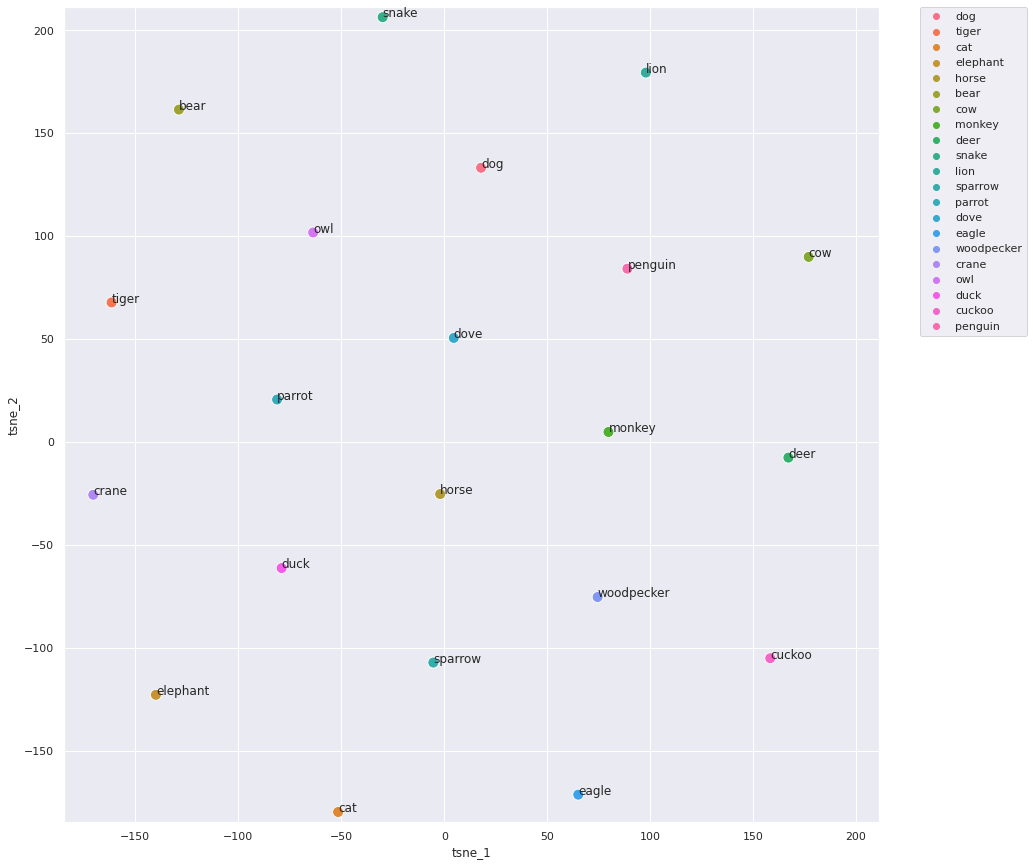

In [35]:
fig, ax = plt.subplots(1)


sns.set(rc={"figure.figsize":(5, 5)}) 
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

for i in range(len(WordsArray)):
    
    plt.annotate(WordsArray[i], (tsne_result[i,0], tsne_result[i,1]))

plt.show()


# Inter -Intra Distance and DB index

In [38]:
Dist_AnimalWord = 0
Dist_Birword = 0
for i in range(len(AnimalWords)):
  #print (i)
  Dist_AnimalWord = Dist_AnimalWord + Get_Embeding(AnimalWords[i],model)  

for j in range(len(BirdWords)):
 #print(j)
  Dist_Birword = Dist_Birword + Get_Embeding(BirdWords[j],model)


AvgIntraDist_Animals = Dist_AnimalWord/len(AnimalWords)
AvgIntraDist_Birds = Dist_Birword/len(BirdWords)

Dis_animal = 0
Dis_bird = 0

for i in range(len(AnimalWords)):
  Dis_animal = Dis_animal + np.sqrt(np.dot((Get_Embeding(AnimalWords[i],model)-Dist_AnimalWord),(Get_Embeding(AnimalWords[i],model)-Dist_AnimalWord)))

for j in range(len(BirdWords)):
  Dis_bird = Dis_bird + np.sqrt(np.dot((Get_Embeding(BirdWords[j],model)-Dist_Birword),(Get_Embeding(BirdWords[j],model)-Dist_Birword)))

Dis_animal = Dis_animal/len(AnimalWords)
Dis_bird = Dis_bird/len(BirdWords)

InterClusterDist = np.sqrt(np.dot(Dist_AnimalWord-Dist_Birword,Dist_AnimalWord-Dist_Birword))

print("intra-cluster distance for animals cluster:",Dis_animal)
print("Intra cluster distance for birds:",Dis_bird)
print("Inter cluster distance:",InterClusterDist)

intra-cluster distance for animals cluster: 30.64425487666381
Intra cluster distance for birds: 24.655697993738794
Inter cluster distance: 31.2569726300766


In [39]:
# We have used the DB index , formula picked up from the pdf shared by sir

SumOfIntraDist = Dis_animal + Dis_bird
DBIndex = SumOfIntraDist/InterClusterDist
print("DB index :",DBIndex)


DB index : 1.769203739750246
